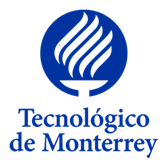

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 5

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Evaluation - Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
!pip install pyarrow

In [2]:
!pip install openpyxl

In [3]:
!pip install langchain

In [4]:
!pip install langchain-community

In [5]:
!pip install langchain-text-splitters

In [6]:
!pip install langchain-aws

In [7]:
!pip install python-dotenv

In [8]:
!pip install pinecone-client

In [9]:
!pip install datasets

In [10]:
!pip install pip install ragas

In [11]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import os

from dotenv import load_dotenv
import pandas as pd
import numpy as np

import pyarrow.parquet as pq
import boto3
import s3fs
import openpyxl

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import BedrockEmbeddings
from langchain_aws import BedrockLLM

from pinecone import Pinecone
from sklearn.metrics.pairwise import cosine_similarity
from renumics import spotlight

from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

In [12]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [13]:
# Configurando constantes para la ejecución. AWS_KBID_Vxxx contiene el identificador de la base
# de conocimientos de AWS Bedrock
load_dotenv()
MAX_ENTRIES = 100
AWS_KBID_V100 = os.environ['AWS_KBID_V100']
AWS_KBID_V200 = os.environ['AWS_KBID_V200']
PINECONE_API_KEY_V100 = os.environ['PINECONE_API_KEY_V100']
INDEX_V100 = 'volindov101'
PINECONE_API_KEY_V200 = os.environ['PINECONE_API_KEY_V200']
INDEX_V200 = 'volindov200'
KB_VERSION = '2.00'

if KB_VERSION == '1.00':
    PINDEX = INDEX_V100
    PKEY = PINECONE_API_KEY_V100
else:
    PINDEX = INDEX_V200
    PKEY = PINECONE_API_KEY_V200


### **Evaluando la Base de Conocimiento y el Modelo Fundacional Visualmente con UMAP**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas. Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Blah, Blah, Blah, Blah

### **Creando Agente para Recuperar Informacion de Contexto**

In [14]:
# Creando clientes para componentes de AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
if KB_VERSION == '1.00':
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V100,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
    )
else:
    retriever = AmazonKnowledgeBasesRetriever(
        knowledge_base_id=AWS_KBID_V200,
        retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
    )

### **Creando Agente para Questionar el Modelo Fundacional**

In [15]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [16]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant. Begin your response with a polite greeting. Accurately use the detailed context provided from the database "
        "to answer the following query, particularly focusing on correct location details. Ensure the locations mentioned are verified against "
        "the context. Provide options within the same city or nearby, double-checking location accuracy. Offer two or three choices when possible. "
        "Address the user by name if provided in the context. If the answer is unknown or if you cannot verify the location details, state 'I don't know'. "
        "Limit responses to three sentences and maintain conciseness. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [17]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
#    for context in response['context']:
#        print(f"\nContexto:\n{context.page_content}")
#        print(f"\nCalificacion:{context.metadata['score']:.6f}")
#        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
#        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


In [18]:
def prepare_emb_space(query, answer, country, index_name, key, entries=1000):
    # Preparando modelo de embeddings de AWS Bedrock Titan Embed Text v1.x
    embeddings = BedrockEmbeddings(model_id='amazon.titan-embed-text-v1')
    
    # Generando un dataframe con embeddings para la pregunta
    query_emb = embeddings.embed_query(query)
    query_emb_df = pd.DataFrame({'id': 'query','query': query,'embeddings': [query_emb]})
    
    # Generando un dataframe con embeddings para la respuesta
    answer_emb = embeddings.embed_query(answer)
    answer_emb_df = pd.DataFrame({'id': 'answer','answer': answer,'embeddings': [answer_emb]})

    # Creando cliente de Pinecone
    pc = Pinecone(api_key=key)
    
    # Recuperando registros del índice de Pinecone para un país en especifico
    index = pc.Index(index_name)
    emb_space = index.query(
        vector=query_emb,
        top_k=entries,
        include_values=True,
        include_metadata=True,
        filter={
            "Country": {"$eq": country}
        }
    )

    # Creando un dataframe con los datos recuperados del índice de Pinecone
    emb_space_df = pd.DataFrame(columns=['id', 'source', 'score', 'document', 'embeddings'])
    for match in emb_space.matches:
        id = match.id
        source = match.metadata['x-amz-bedrock-kb-source-uri']
        score = match.score
        document = match.metadata['hotel-data']
        embeddings = match.values
        emb_space_df = pd.concat(
            [
                emb_space_df,
                pd.DataFrame({'id': id, 'source': source, 'score': score, 'document': document, 'embeddings': [embeddings]})
            ],
            ignore_index=True
        )

    # Creando un dataframe con los registros para la pregunta, la respuesta y los datos
    # recuperados de Pinecone
    emb_space_df = pd.concat([query_emb_df, answer_emb_df, emb_space_df])

    # Calculando la distancia de coseno para cada registro
    emb_space_df['distance'] = emb_space_df.apply(
        lambda row: 1 - (
            np.dot(row['embeddings'], answer_emb) / (np.linalg.norm(row['embeddings']) * np.linalg.norm(answer_emb))
        ),
        axis=1
    )

    return emb_space_df


### **Ejecutando la Evaluación**

**Obteniendo Preguntas y Respuestas Sintéticas**

In [19]:
SOURCE_AWS_BUCKET = 'volindo-hotel-data'
TARGET_DATA_FILE = f'hotel-clean-data-set/synthetic-data/hotel-data-set-4p-results.xlsx'
SOURCE_DATA_FILE = f's3://{SOURCE_AWS_BUCKET}/hotel-clean-data-set/synthetic-data/hotel-data-set-4p.snappy.parquet'


In [20]:
# Creando sistemas de archivos para bucket de S3
awsfs = s3fs.S3FileSystem()

# Creando cliente para AWS S3
s3_client = boto3.client('s3')


In [21]:
# Leyendo preguntas y respuestas sintéticas
dataset = pq.ParquetDataset(SOURCE_DATA_FILE, filesystem=awsfs)
table = dataset.read()
eval_dataframe = table.to_pandas()


In [22]:
eval_dataframe.shape

(426, 6)

In [23]:
eval_dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   question            426 non-null    object
 1   answer              426 non-null    object
 2   groundedness_score  426 non-null    int64 
 3   groundedness_eval   426 non-null    object
 4   relevance_score     426 non-null    int64 
 5   relevance_eval      426 non-null    object
dtypes: int64(2), object(4)
memory usage: 20.1+ KB


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [24]:
questions = []
truths = []
answers = []
contexts = []

subi = 0
for eval in eval_dataframe.itertuples():
    questions.append(eval.question)
    truths.append(eval.answer)
    input = eval.question
    
    elapsed_time, response = retrieve_and_generate(input, retriever, llm)
    answers.append(response['answer'])
    contexts.append([res.page_content for res in response['context']])

    subi += 1
    if subi > 4:
        break

In [25]:
eval_data = {
    'question': questions,
    'answer': answers,
    'contexts': contexts,
    'ground_truth': truths
}
eval_data_dataset = Dataset.from_dict(eval_data)

**Evaluación**

In [26]:
results = evaluate(
    dataset = eval_data_dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)



Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
results_df = results.to_pandas()

In [28]:
results_df.head()

,question,answer,contexts,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,How far is Coral Beach Resort Sharjah from Cit...,Coral Beach Resort Sharjah is 14.1 mi (22.7 km...,[HeadLine : Near Sharjah Ladies ClubLocation :...,Coral Beach Resort Sharjah is 14.1 mi (22.7 km...,0.916667,0.0,1.0,1.000000
1,In which city is Radisson Dubai Damac Hills lo...,Radisson Dubai Damac Hills is located in Dubai.,[HeadLine : Near Trump International Golf Club...,Radisson Dubai Damac Hills is located in Dubai...,0.804167,1.0,1.0,0.976964
2,What are the distances to Burj Khalifa and Mus...,Hi there! Millennium Plaza Downtown Suites is ...,[HeadLine : Near Museum of the FutureLocation ...,Burj Khalifa is 2.4 mi (3.9 km) and Museum of ...,0.887500,1.0,0.5,0.964486
3,In which city is Hotel Restorant Delisia located?,Hotel Restorant Delisia is located in Korçë.,"[Featuring 4-star accommodation, Hotel Restora...","Korçë, Albania",0.700000,1.0,1.0,0.979527
4,How far is Municipal Aquarium Mendoza from Mod...,Mod Hotels Mendoza is 0.4 mi (0.7 km) from Mun...,[HeadLine : In Mendoza (Mendoza City Center)Lo...,Municipal Aquarium Mendoza is 0.4 mi (0.7 km) ...,1.000000,1.0,0.0,0.990225


**Salvando resultados de la evaluacion**

In [29]:
with io.BytesIO() as excel_file:
    results_df.to_excel(excel_file,index=False)
    response = s3_client.put_object(
        Bucket=SOURCE_AWS_BUCKET, Key=TARGET_DATA_FILE, Body=excel_file.getvalue()
    )
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    

<Axes: title={'center': 'Evaluacion de KB 2.00 Usando RAGAs'}>

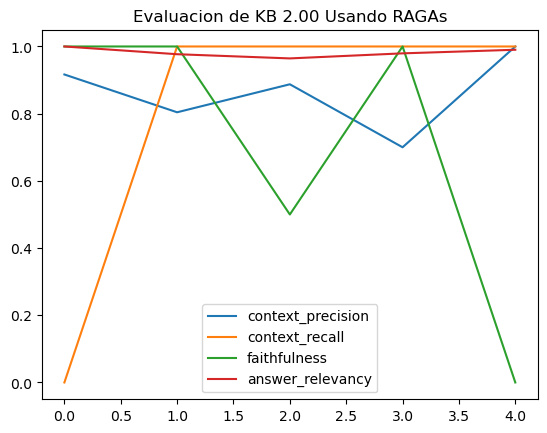

In [30]:
results_df.plot(
    kind='line',
    y=['context_precision','context_recall','faithfulness','answer_relevancy'],
    use_index=True,
    title='Evaluacion de KB 2.00 Usando RAGAs'
)

<Axes: title={'center': 'Evaluacion de KB 2.00 Usando RAGAs'}>

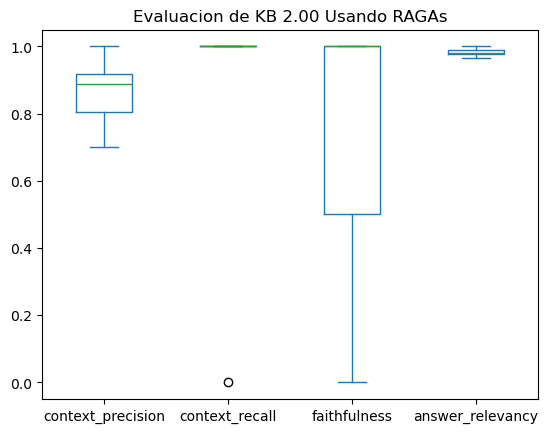

In [31]:
results_df.plot(
    kind='box',
    y=['context_precision','context_recall','faithfulness','answer_relevancy'],
    use_index=True,
    title='Evaluacion de KB 2.00 Usando RAGAs'
)

## **Conclusiones**


La presentación de los nuevos modelos y la selección del mejor modelo se encuentran en el archivo ***Avance5 Smart Travel Assistant-Reporte de Progreso-02.pptx*** en el mismo repositorio de esta libreta.

## **Referencias**

* Es, S., James, J., Espinosa-Anke, L., & Schockaert, S. (2023). RAGAS: Automated Evaluation of Retrieval Augmented Generation. ArXiv (Cornell University). https://doi.org/10.48550/arxiv.2309.15217
* Monigatti, L. (2023, 15 de diciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a


* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html
